In [61]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

### Initial data reading
#### Read the folder files with the mean of $e_{normal}$ and $e_{tumor}$
1. Store names in a list
2. Store values in a list of list to transform later into an array

In [6]:
folder_path = "./mean_exp_values"
file_list = []
data_store = []

for file in os.listdir(folder_path):
    # store the file name withouth path and extention
    file_list.append(file.split('.')[0])
    # store the data from each file
    data_store.append(pd.read_csv(folder_path+'/'+file,
                                  sep='\t',header=None).iloc[:,0])
# numpy array
data_store = np.array(data_store)

### Preparing data

Separating tumor and normal mean values by using numpy mask to evaluate in array and listing tissues and genes

In [7]:
# Creating masks
normal_mask = [name[:6] == 'normal' for name in file_list]
tumor_mask = [name[:5] == 'tumor' for name in file_list]

# List of different tissues
tissues = np.unique(
    [''.join(re.findall('[A-Z]', string)) for string in file_list]
    )
# Ensemble IDs
ensbl = pd.read_csv("ensemble.txt",sep='\t',header=None).iloc[:,0]

Precalculus matrix of differential expression:
$$ Log2 FC = Log2 (e/e_{ref})$$
df $->$ DataFrame with features as columns: ensemble IDs and samples as index: tissues

In [8]:
# Calculate log2 fold-change of gene exprssion with normal tissue as reference
Log2FC = np.log2(data_store[tumor_mask]/data_store[normal_mask])

# DataFrame of gene expression fold-change
df = pd.DataFrame(data=Log2FC,columns=ensbl,index=tissues)

### Pathways
#### Top 28 pathways from Reactome
Read the pathway data and store pathway names and genes in pathways

In [9]:
# Read the Top 28 pathways excel list
top_pathways = pd.read_excel("pathways2_sorted.xls",header=None)
# Name the columns
top_pathways.columns = ["Ensemble","Pathways"]

# Count pathways
pathways_names = pd.unique(top_pathways.Pathways)
# Count genes in pathways
genes_annotated = pd.unique(top_pathways.Ensemble)

# Print ranges
print(" Top Pathways:",
      pathways_names.shape[0],"\n",
      "Annotated Genes:",
      genes_annotated.shape[0]
      )

 Top Pathways: 28 
 Annotated Genes: 10785


Get matching genes in pathways and evaluate in top-pathways dataframe

In [25]:
# Genes in pathways
genes_path = set(ensbl) & set(genes_annotated)

# Pathways with annotated genes
pathways_annotated = top_pathways.query('Ensemble in @genes_path')

In [77]:
X = []
for pathway in pathways_names:
    # genes evaluated in pathway (variable to operate)
    g_pathways = df[
        pathways_annotated[pathways_annotated.Pathways == pathway].Ensemble
    ]
    # Ecuation above
    X.append(np.sum(abs(g_pathways),axis=1)/g_pathways.shape[1])

X = pd.DataFrame(data=X, columns=tissues,index=pathways_names)

In [79]:
pca = PCA(3)
P_matrix = pca.fit_transform(X.T)
print(P_matrix.shape)

(15, 3)


In [80]:
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
variance_cumulative = pca.explained_variance_ratio_.cumsum()

print(eigenvectors.shape)

(3, 28)


In [81]:
proyections_table = pd.DataFrame(P_matrix, columns=[f'PC{i}' for i in range(1, 4)])
#file_name = 'PCAproyections.xlsx'
#proyections_table.to_excel(file_name)

#proyections_table['Sample Type'] = sample.Sample_Type

#primary_tumor = (sample.Sample_Type.values == 'Primary Tumor')
#metastatic = (sample.Sample_Type.values == 'Metastatic')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

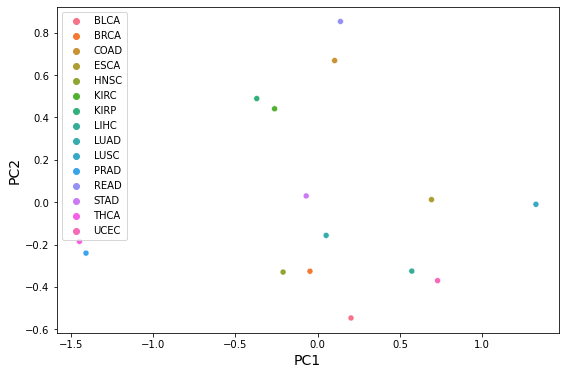

In [86]:
plt.figure(figsize = (9,6))
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue = X.columns)